In [21]:
import uproot
import awkward as ak
import numpy as np
import sys
#sys.path.insert(0, "/home/llr/cms/cuisset/.local/lib/python3.11/site-packages") # for latest mplhep version
sys.path.insert(0, "/home/llr/cms/cuisset/.virtualenvs/modules-python-3.12-el9/lib/python3.12/site-packages")
import hist
import matplotlib.pyplot as plt
import matplotlib, matplotlib.gridspec
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import cycler, itertools


In [37]:
year="2016_HIPM"
btag_systs_nojec = ["cferr1", "cferr2", "hf", "hfstats1", "hfstats2", "lf", "lfstats1", "lfstats2"]
btag_systs_jec = ["jesFlavorQCD", "jesRelativeBal", "jesHF", "jesBBEC1", "jesEC2", "jesAbsolute",
    f"jesBBEC1_{year}", f"jesEC2_{year}", f"jesAbsolute_{year}", f"jesHF_{year}", f"jesRelativeSample_{year}"]

jec_nba_to_branch_map = {
"jec_1": "_smeared_FlavorQCD",
"jec_2": "_smeared_RelativeBal",
"jec_3": "_smeared_HF",
"jec_4": "_smeared_BBEC1",
"jec_5": "_smeared_EC2",
"jec_6": "_smeared_Absolute",
"jec_7": f"_smeared_BBEC1_{year}",
"jec_8": f"_smeared_EC2_{year}",
"jec_9": f"_smeared_Absolute_{year}",
"jec_10": f"_smeared_HF_{year}",
"jec_11": f"_smeared_RelativeSample_{year}",
}
all_systs = ["CMS_btag_" + s for s in btag_systs_nojec] + list(jec_nba_to_branch_map.keys())

In [38]:
def open_featureHistogram(feature, process, region, with_btag:bool, with_systs=True):
    if with_btag:
        prod_version = "prod_250315_btag_0604_withbTagWeight_v7" #"prod_250315_btag_3103_withbTagWeight_v7" #prod_250315_btag_extrap_factor_systs_withbTagWeight
    else:
        prod_version = "prod_250315_btag_0604_nobTagWeight" #'prod_250315_btag_extrap_factor_systs_nobTagWeight' 
    with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeatureHistogram/bul_{year}_ZZ_v12/cat_baseline_resolved_nobtag/{prod_version}/root/{feature}__{region}_region__pg_zz__nodata.root:histograms") as folder:
        res = {
            "nominal" : folder[process].to_hist(),
        }
        if with_systs:
            for syst in all_systs:
                for dir in ["up", "down"]:
                    res[syst + "_" + dir] = folder[f"{process}_{syst}_{dir}"].to_hist()
        return res
def open_preplot(feature, process, region, with_btag:bool, with_systs=True): # /grid_mnt/data__data.polcms/cms/cuisset/cmt/PrePlot/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M1000/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_systs/data__baseline_region__removeWeights_hem_weight_0.root
    if with_btag:
        prod_version = 'prod_250315_btag_0604_v7'#"prod_250315_btag_3103_v6" #prod_250315_btag_extrap_factor_systs
    else:
        prod_version = 'prod_250315_btag_0604' #'prod_250315_btag_extrap_factor_systs' 
    #with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PrePlot/bul_{year}_ZZ_v12/{process}/cat_baseline_resolved_nobtag/{prod_version}/data__{region}__removeWeights_{'' if with_btag else 'bTagweightReshape_'}hem_weight_0.root:{feature}") as folder:
    # data__baseline_region__removeWeights_bTagweightReshape_bTagweightReshapeExtrapFactor_hem_weight_0
    with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PrePlot/bul_{year}_ZZ_v12/{process}/cat_baseline_resolved_nobtag/{prod_version}/data__{region}__removeWeights_{'' if with_btag else 'bTagweightReshape_bTagweightReshapeExtrapFactor_'}hem_weight_0.root:{feature}") as folder:
        res = {
            "nominal" : folder[feature].to_hist(),
        }
        if with_systs:
            for syst in all_systs:
                for dir in ["up", "down"]:
                    res[syst + "_" + dir] = folder[f"{feature}_{syst}_{dir}"].to_hist()
        return res
# def makeTotalHists(hists):
#     res = {}
#     for syst_dir in hists[0].keys():
#         res[syst_dir] = sum(process_hists[syst_dir] for process_hists in hists)
#     return res

def sum_templates_quadrature(hs, systs, flow=False):
    flow = False
    central = hs["nominal"]
    up_sum_quadrature, down_sum_quadrature = np.zeros_like(central.view(flow).value), np.zeros_like(central.view(flow).value)
    for syst in systs:
        up, down = [hs[syst + "_up"], hs[syst + "_down"]]
        up_diff = up.view(flow).value-central.view(flow).value
        down_diff = down.view(flow).value-central.view(flow).value
        up_sum_quadrature += np.square(np.maximum(up_diff, 0.)+ np.maximum(down_diff, 0.))
        down_sum_quadrature += np.square(np.minimum(up_diff, 0.)+ np.minimum(down_diff, 0.))
    return central, up_sum_quadrature, down_sum_quadrature
# possible features : nJet,LHE_HT,LHE_HT_low,LHE_HT_high,jet_btag_count_total,jet_btagcand_count
feature_label = {"nJet": "Number of AK4 jets"}
btag_mode_label = {"reshape" : "With b-tag reshaping weight", "noWeight" : "No b-tag reweighting"}

In [39]:
# hs_btag = open_featureHistogram(feature=feature_name, process=process, region="baseline", with_btag=True)
# hs_nobtag = open_featureHistogram(feature=feature_name, process=process, region="baseline", with_btag=False)

In [8]:
def plot_sum_quadrature():
    flow=False
    central, up_sum_quadrature, down_sum_quadrature=sum_templates_quadrature(hs, all_systs, flow=flow)
    hep.histplot([hs["nominal"].view(flow).value, hs["nominal"].view(flow).value+np.sqrt(up_sum_quadrature), hs["nominal"].view(flow).value-np.sqrt(down_sum_quadrature)], 
                    bins=hs["nominal"].axes[0].edges,
                    label=["central", "Up", "Down"])

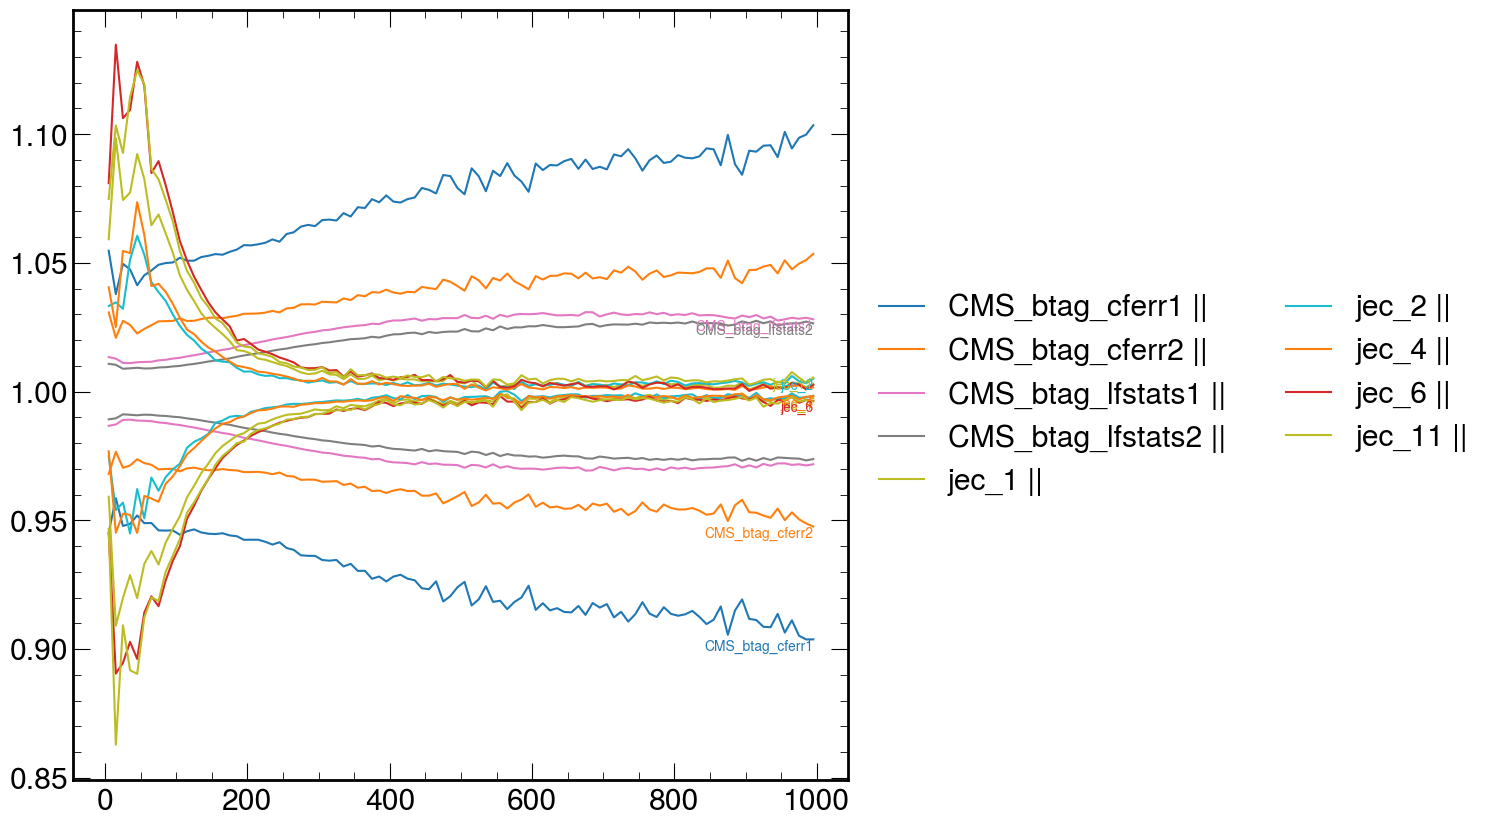

In [50]:
# plotting variation from every systematic
central = hs["nominal"]
for syst, color in zip(all_systs, itertools.cycle(mcolors.TABLEAU_COLORS)):
    up = hs[syst + "_up"]
    down = hs[syst + "_down"]
    down_vals = (down.view(flow).value)/central.view(flow).value
    if abs(np.average(down_vals) - 1)>0.02 or np.max(np.abs(down_vals - 1)) > 0.05:
        large_var = True
    else:
        large_var = False
        continue
    
    
    plt.plot(central.axes[0].centers, (up.view(flow).value)/central.view(flow).value, label=syst + (" ||" if large_var else ""), color=color)
    plt.plot(central.axes[0].centers, (down.view(flow).value)/central.view(flow).value, color=color) # label=syst + " down",
    
    if large_var:
        plt.text(central.axes[0].centers[-1], down_vals[-1], syst, fontsize=10, ha="right", va="top", color=color)
plt.legend(ncols=2, loc="center left", bbox_to_anchor=(1, 0.5))

In [6]:
def plot(process, feature):
    btag_modes = ["reshape", "noWeight"]
    hs = {btag_mode : load_histo(process, btag_mode, feature) for btag_mode in btag_modes}

    plt.figure()
    # plt.title(region)
    # plt.rc('axes', prop_cycle=cycler.cycler(color= [plt.get_cmap('tab20')(i) for i in range(20)]))
    hep.histplot(list(hs.values()), label=[btag_mode_label.get(k, k) for k in hs.keys()], yerr=False)
    plt.xlabel(feature_label.get(feature, feature))
    plt.ylabel("Events")
    #hep.histplot(hs[process_signal]["central"]*10, histtype="step", yerr=True, label="signal")
    plt.legend()
    # plt.yscale("log")
    # plt.ylim(bottom=1)


# comparing with & without btag

/tmp/ipykernel_1065988/2372057486.py:29: RuntimeWarning: invalid value encountered in divide
  hist.plot.plot_ratio_array(hs_btag["nominal"], hs_btag["nominal"].values()*reshape_extrap_ratio/hs_nobtag["nominal"].values(), np.zeros_like(hs_nobtag["nominal"].values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
/tmp/ipykernel_1065988/2372057486.py:29: RuntimeWarning: invalid value encountered in divide
  hist.plot.plot_ratio_array(hs_btag["nominal"], hs_btag["nominal"].values()*reshape_extrap_ratio/hs_nobtag["nominal"].values(), np.zeros_like(hs_nobtag["nominal"].values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
/tmp/ipykernel_1065988/2372057486.py:29: RuntimeWarning: invalid value encountered in divide
  hist.plot.plot_ratio_array(hs_btag["nominal"], hs_btag["nominal"].values()*reshape_extrap_ratio/hs_nobtag["nominal"].values(), np.zeros_like(hs_nobtag["nominal"].values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
/tmp/ipykernel_1065988/2372057486.py:29: RuntimeWarning: invalid value

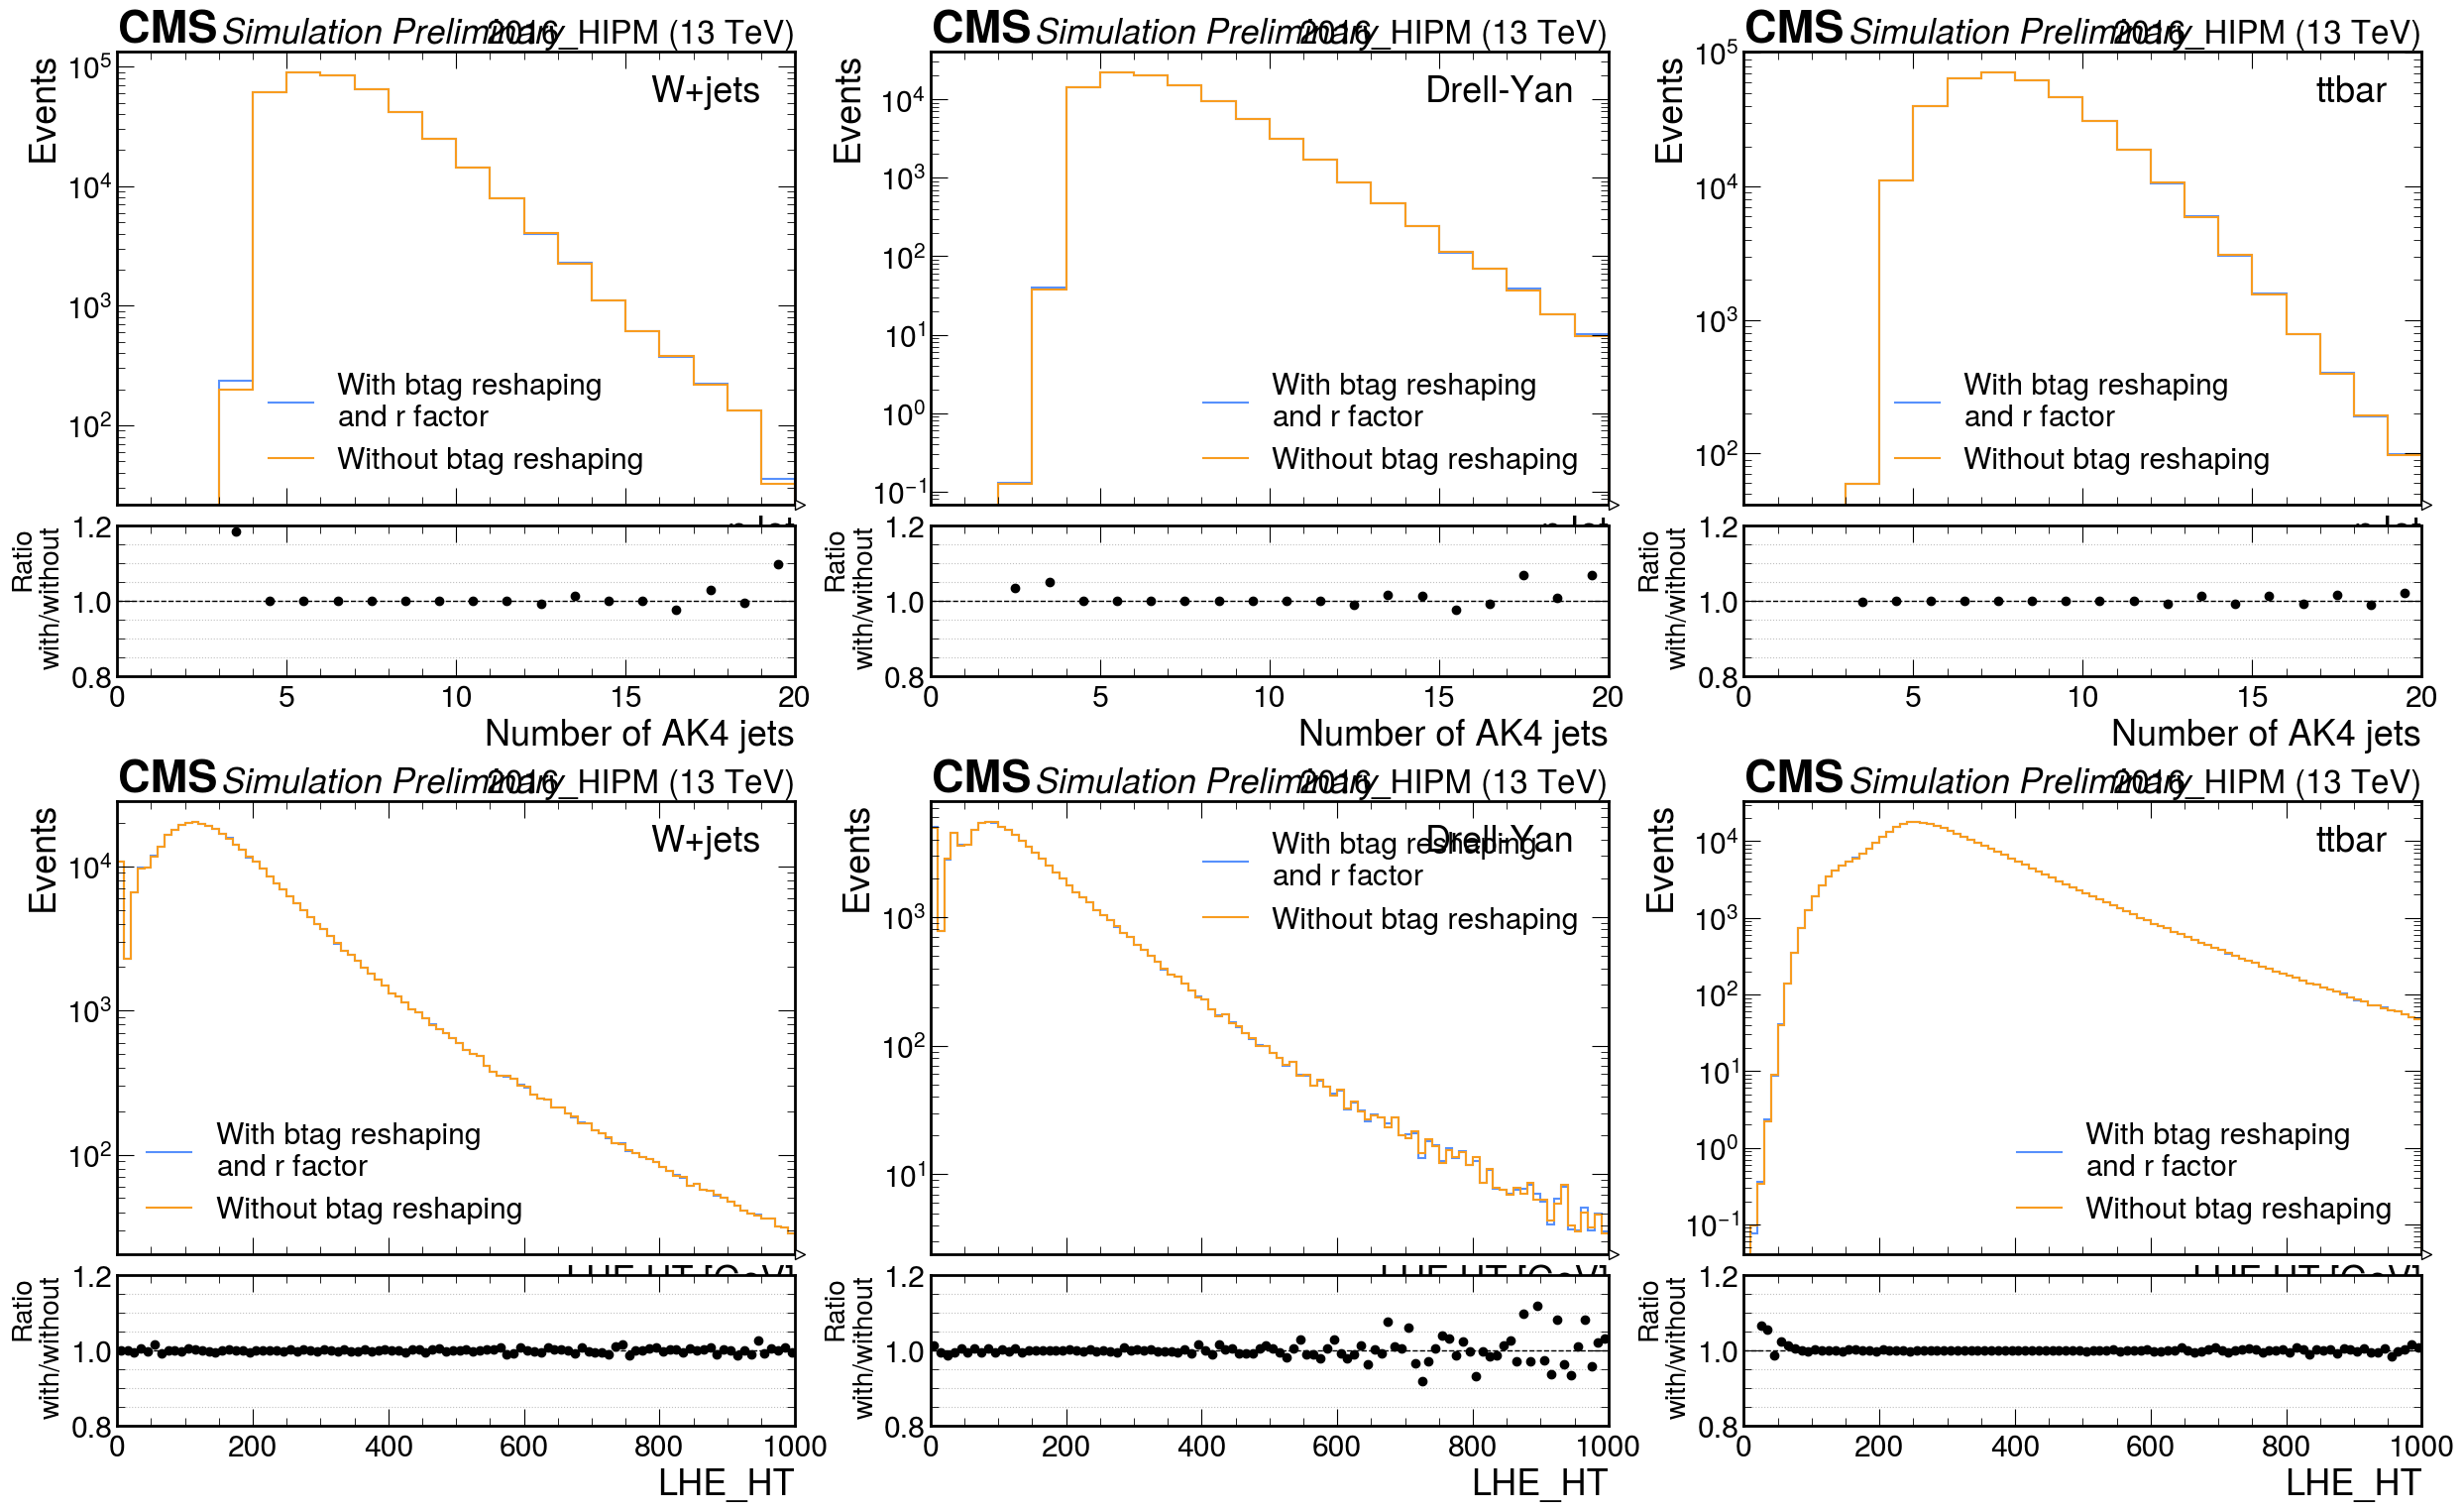

In [40]:
process_label_map = {"dy":"Drell-Yan", "wjets":"W+jets", "tt": "ttbar"}
processes = ["wjets", "dy", "tt"]
features = ["nJet", "LHE_HT"]
# fig, axs = plt.subplots(len(features), len(processes))
fig = plt.figure(figsize=(len(processes)*10, len(features)*9))
outer = matplotlib.gridspec.GridSpec(len(features), len(processes), wspace=0.2, hspace=0.2)
i = 0
for feature in features:
    for process  in processes:
    
        hs_btag = open_featureHistogram(feature=feature, process=process, region="baseline", with_btag=True, with_systs=False)
        hs_nobtag = open_featureHistogram(feature=feature, process=process, region="baseline", with_btag=False, with_systs=False)


        reshape_extrap_ratio = 0.9671699313416069
        reshape_extrap_ratio = 1. # already in ntuples
        import hist.plot
        grid = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], hspace=0.07, height_ratios=[3, 1])
        #grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

        #main_ax = plt.Subplot(fig, grid[0])
        main_ax:plt.Axes = fig.add_subplot(grid[0])
        main_ax.set_yscale("log")
        subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)
        #subplot_ax:plt.Axes = plt.Subplot(fig, grid[1], sharex=main_ax)

        hep.histplot([hs_btag["nominal"]*reshape_extrap_ratio, hs_nobtag["nominal"]], yerr=False, label=["With btag reshaping\nand $r$ factor", "Without btag reshaping"], ax=main_ax)
        hist.plot.plot_ratio_array(hs_btag["nominal"], hs_btag["nominal"].values()*reshape_extrap_ratio/hs_nobtag["nominal"].values(), np.zeros_like(hs_nobtag["nominal"].values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
        
        main_ax.set_ylabel("Events")
        subplot_ax.set_xlabel(feature_label.get(feature, feature))
        subplot_ax.set_ylabel("Ratio\nwith/without", size=20)
        plt.setp(main_ax.get_xticklabels(), visible=False)
        subplot_ax.grid(axis="y", which="both")
        hep.cms.label(year=year, data=False, label="Preliminary", ax=main_ax, fontsize=25,) # "Simulation Preliminary", fontsize=25,
        main_ax.text(0.95, 0.95, process_label_map.get(process, process), transform=main_ax.transAxes, ha="right", va="top")

        main_ax.legend(loc="best")

        i+= 1
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/background_check_{year}.pdf", bbox_inches="tight")

## signals : from PrePlot

In [41]:
ht_axis = open_preplot("nJet", "GluGluToXToZZTo2B2Tau_M1000", "baseline_region", False, with_systs=False)["nominal"].axes[0]
ht_axis.edges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [42]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def get_rebin_signal_ztthbb(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 5, 7, 12, 20]), hist.rebin(edges=[0, 10, 20, 40, 70, 100, 170, 300, 450, 600, 5000])
    if mass ==500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 300, 5000])
    if mass ==600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 180, 250, 320, 5000])
    if mass ==700:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 230, 290, 340, 400, 5000])
    if mass ==800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 250, 320, 450, 5000])
    if mass ==1000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 300, 400, 550, 5000])
    if mass ==1200:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 350, 500, 700, 5000])
    if mass ==1400:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 550, 750, 5000])
    if mass ==1600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 450, 700, 900, 5000])
    if mass ==1800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 500, 750, 1100, 5000])
    if mass ==2500:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 700, 1000, 1500, 5000])
    if mass ==3000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 900, 1300, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==3500:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1000, 1500, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==4000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1500, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2500), 5000])
    if mass <=5000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2300), find_nearest(ht_axis.edges, 3000), 5000])
    if mass <=6000:
        return hist.rebin(edges=[0, 6, 8, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 2800), 5000])
    #return get_rebin_signal_zz(mass)
    raise ValueError(mass)
def get_rebin_signal_zbbhtt(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 5, 7, 12, 20]), hist.rebin(edges=[0, 90, 130, 160, 200, 300, 400, 600, 5000])
    if mass ==500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 250, 5000])
    if mass ==600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 180, 250, 290, 5000])
    if mass ==700:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 200, 270, 320, 350, 5000])
    if mass ==800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 250, 320, 450, 5000])
    if mass ==1000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 300, 400, 550, 5000])
    if mass ==1200:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 350, 500, 700, 5000])
    if mass ==1400:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 550, 750, 5000])
    if mass ==1600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 450, 650, 800, 5000])
    if mass ==1800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2500:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 700, 1000, 1500, 5000])
    if mass ==3000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 900, 1300, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==3500:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1000, 1500, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==4000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1500, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2500), 5000])
    if mass <=5000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2300), find_nearest(ht_axis.edges, 3000), 5000])
    if mass <=6000:
        return hist.rebin(edges=[0, 6, 8, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 2600), 5000])
    #return get_rebin_signal_zz(mass)
    raise ValueError(mass)

def get_rebin_signal_zz(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 7, 10, 20]), hist.rebin(edges=[0, 100, 200, 300, 500,1000])
    if mass < 300:
        return hist.rebin(edges=[0, 7, 9, 11, 20]), hist.rebin(edges=[0, 80, 130, 200, 300, 1000])
    elif mass <= 500:
        return hist.rebin(edges=[0, 7, 10, 13, 20]), hist.rebin(edges=[0, 120, 180, 250, 300, 400, 1000])
    elif mass <= 800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 300, 350, 400, 450, 500, 600, 1000])
    elif mass <= 1500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 200, 300, 400, 500, 600, 800, 1000])
    elif mass <= 2500:
        return hist.rebin(edges=[0, 6, 8, 10, 12, 20]), hist.rebin(edges=[0, 250, 400, 600, 800, 1000, 1200, 1000])
    elif mass <= 3500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 700, 1000, 1300, find_nearest(ht_axis.edges, 1700), 1000])
    elif mass <= 5000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 1000, find_nearest(ht_axis.edges, 1700), find_nearest(ht_axis.edges, 2500), 1000])


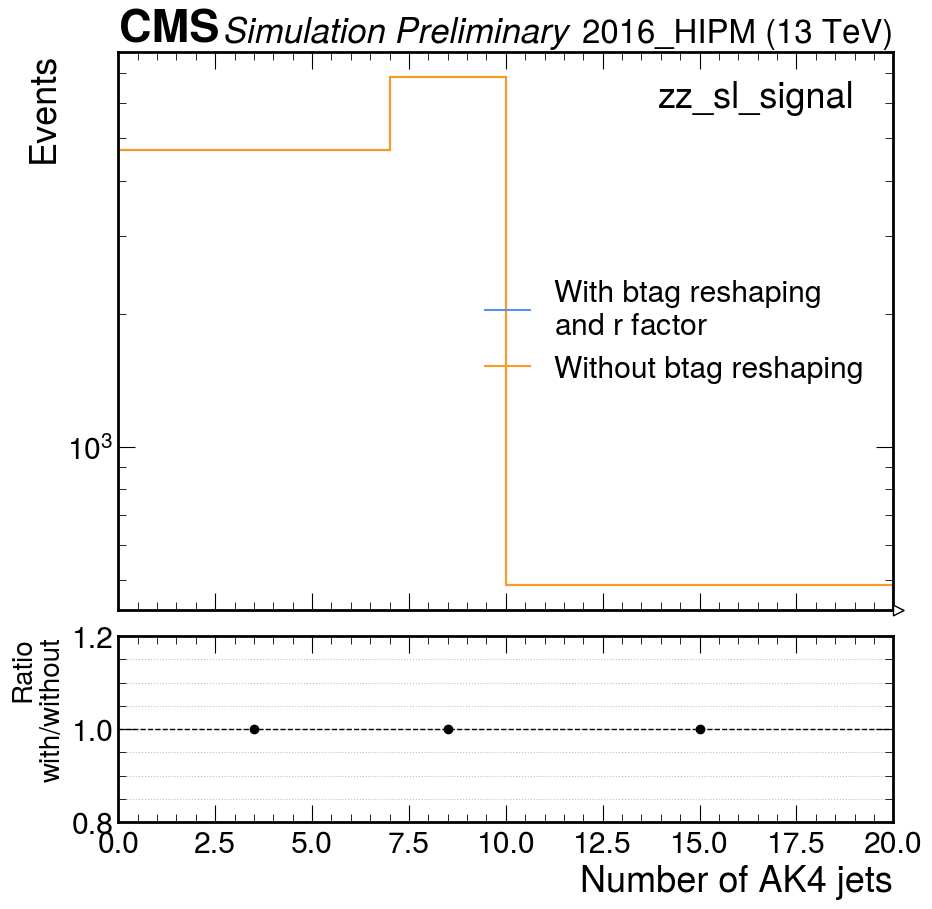

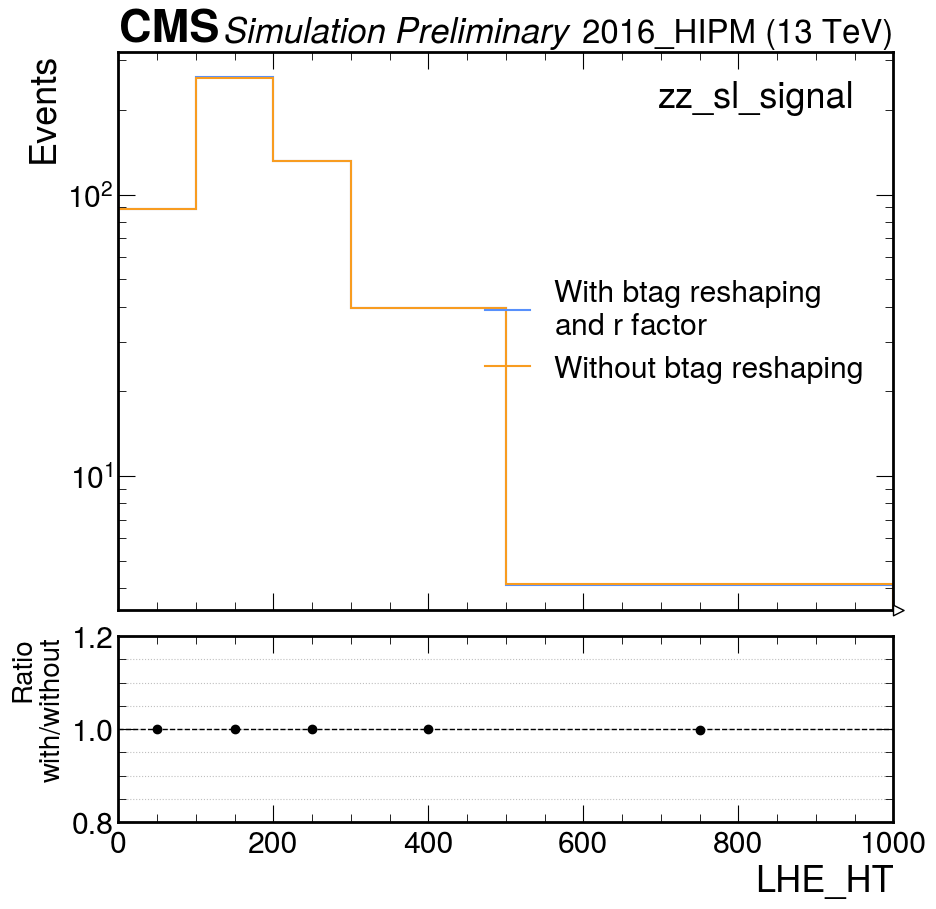

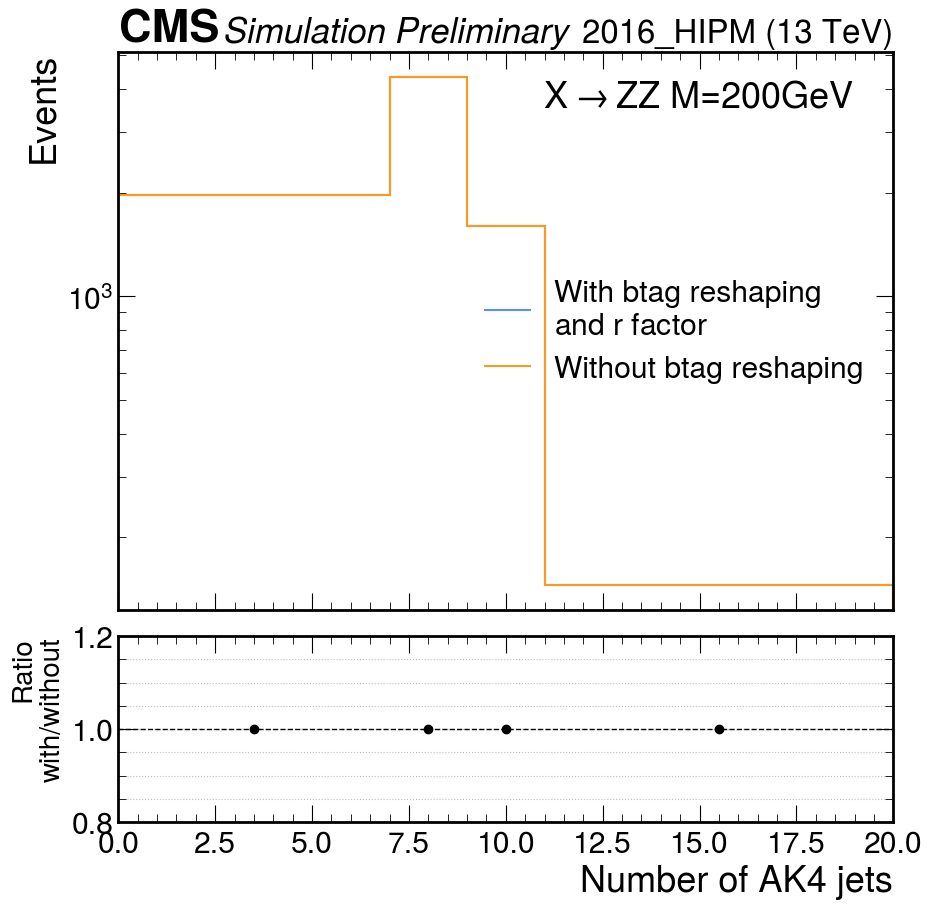

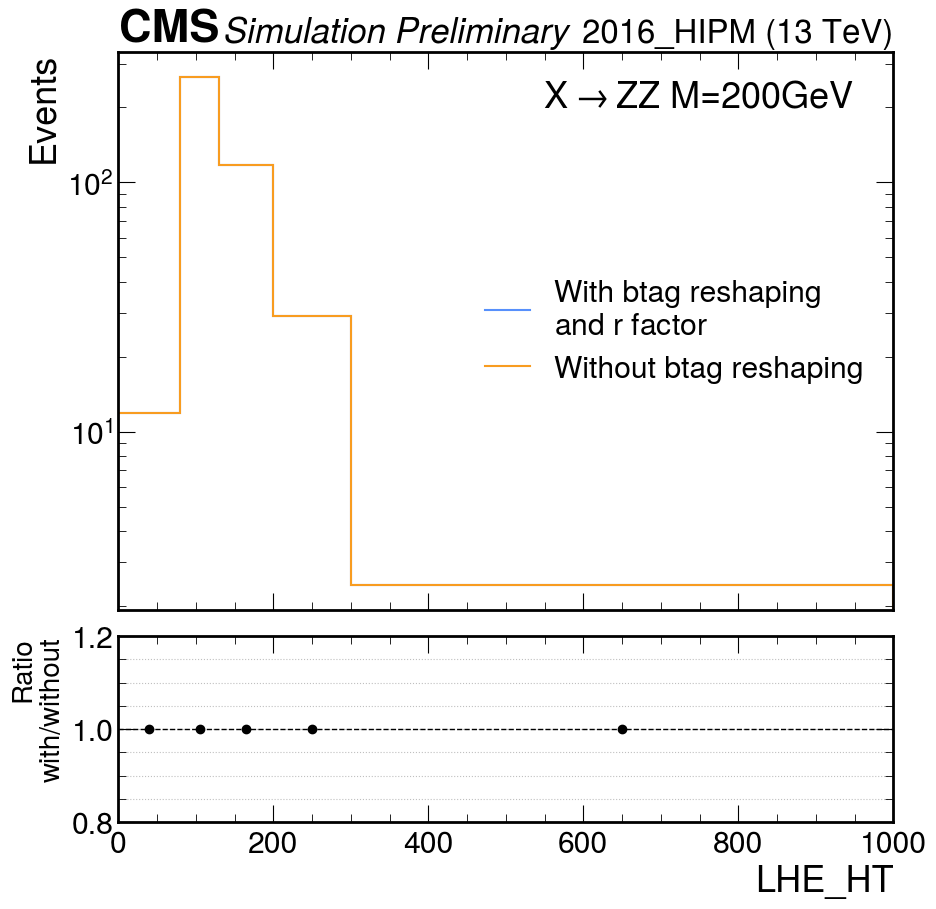

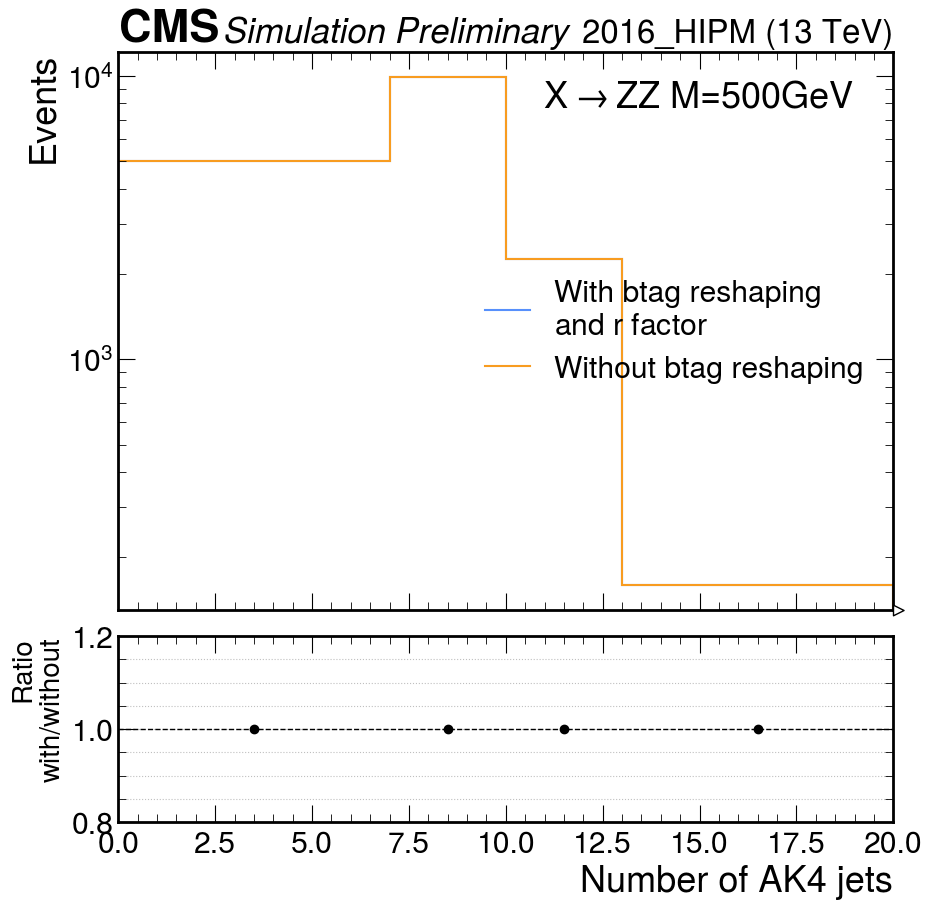

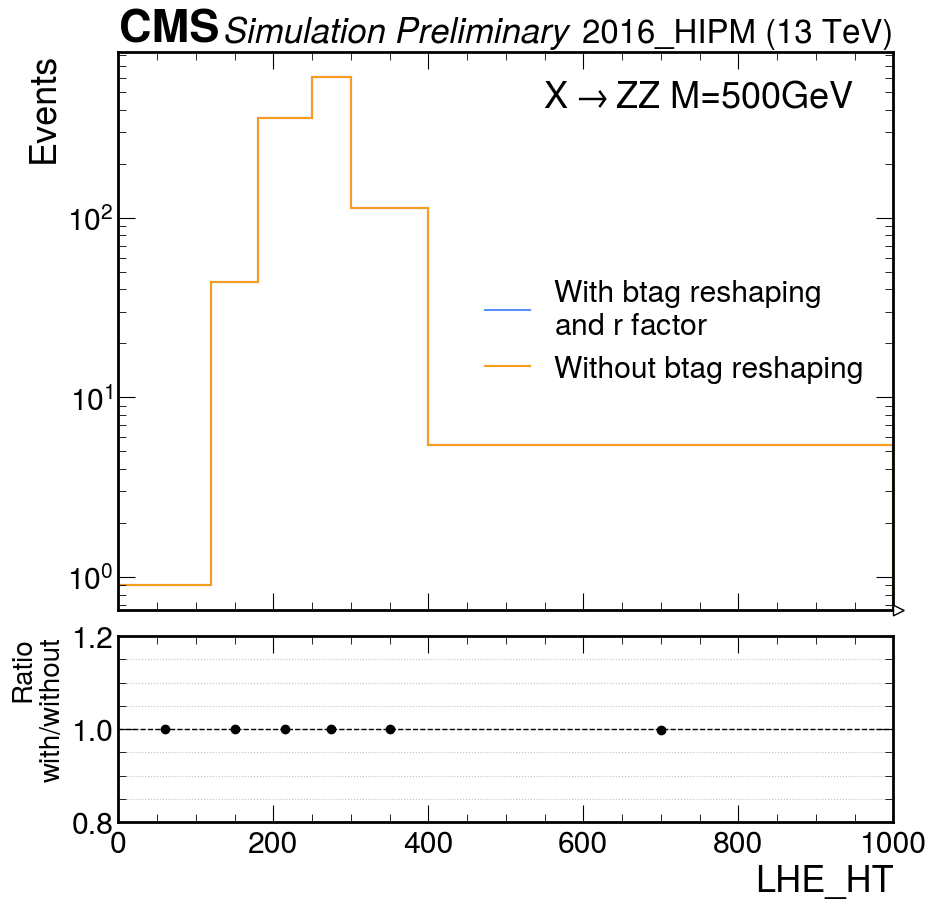

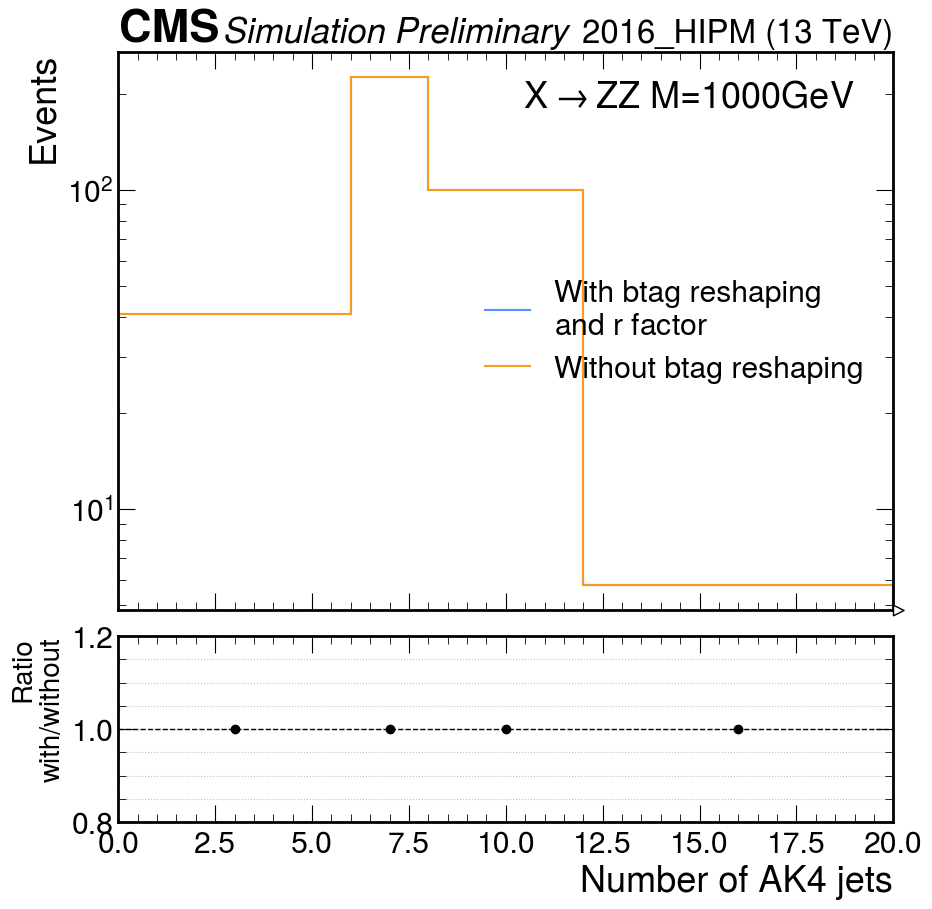

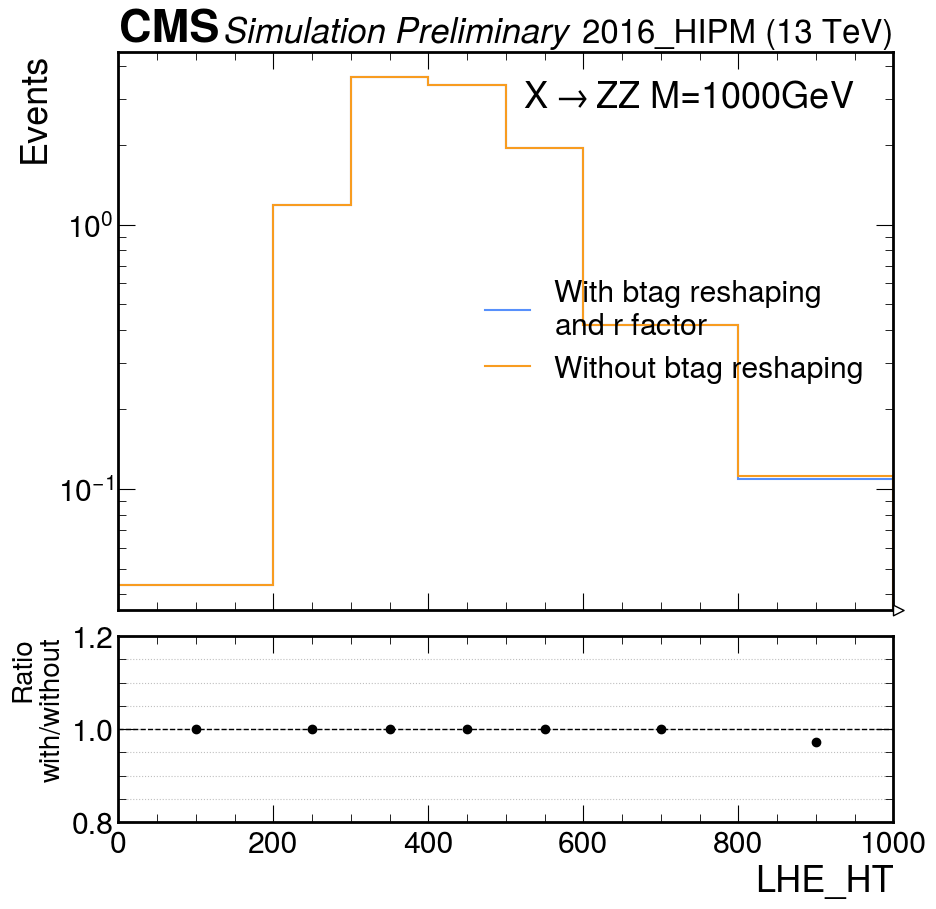

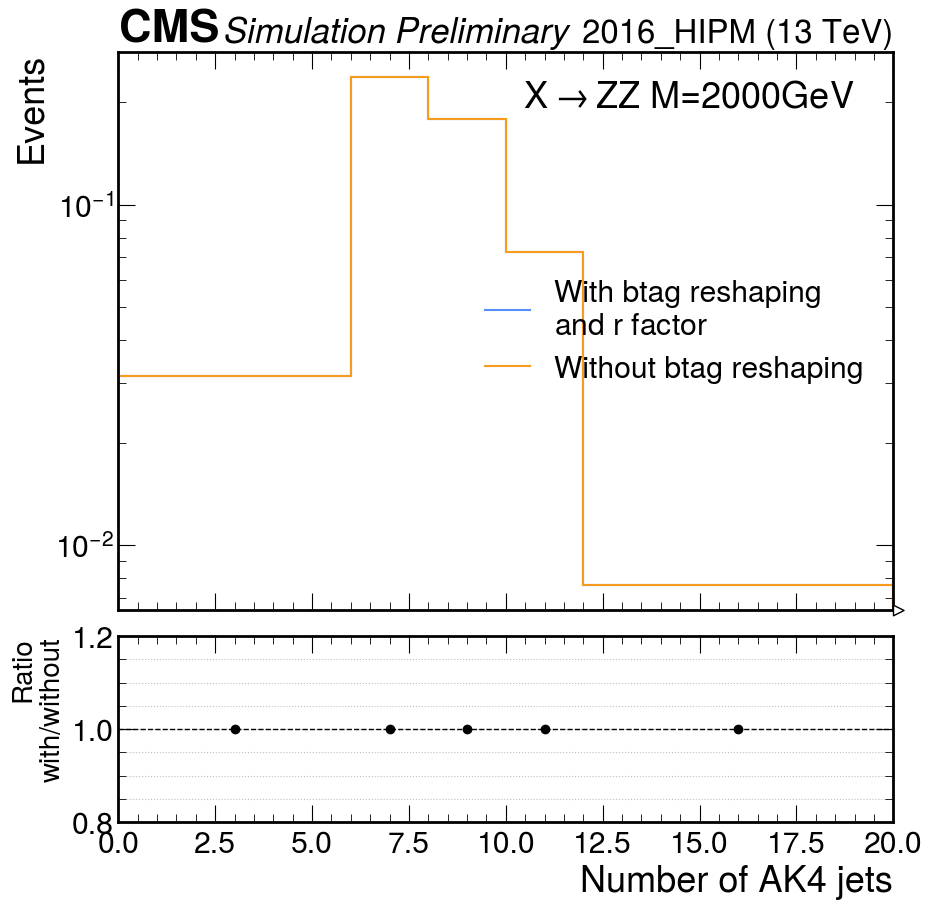

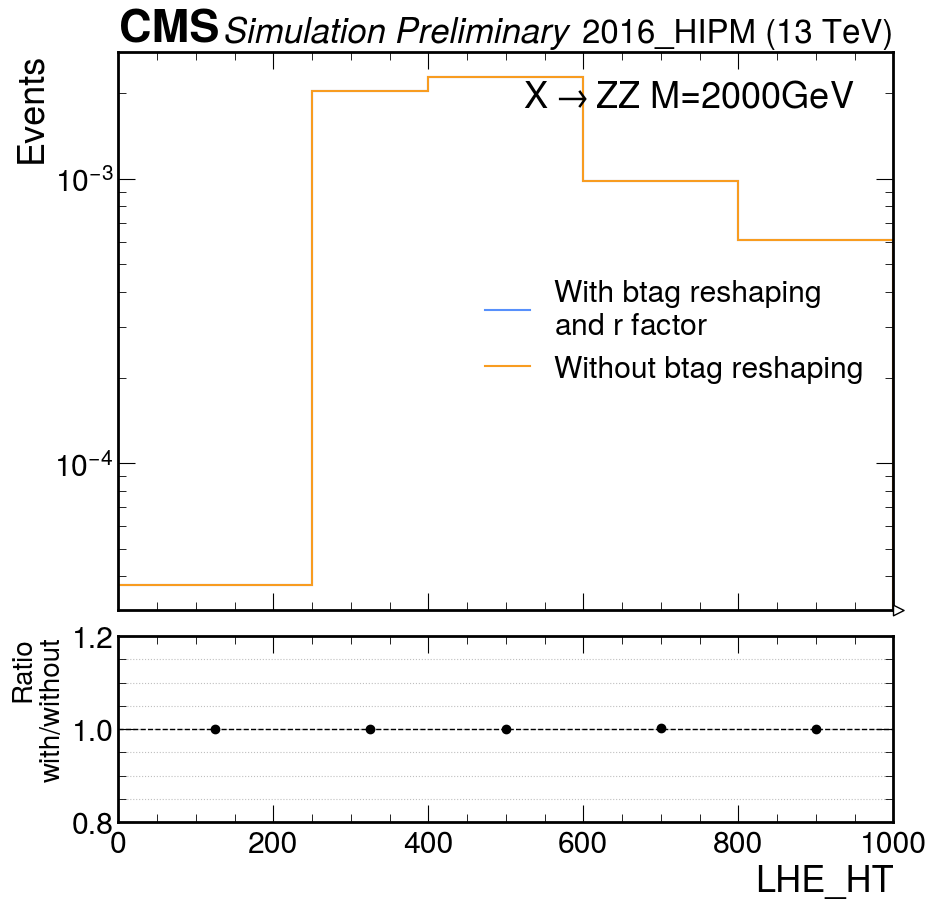

In [43]:
resonant_masses_ZZ = [ 200, 210, 220, 230, 240, 250, 260, 270, 280, 300, 320, 350, 360, 400, 450, 500, 550,
                600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                1800, 1900, 2000, 2200, 2400, 2500, 2600, 2800, 3000, 3500, 4000, 4500, 5000]
process_label_map = {"dy":"Drell-Yan", "wjets":"W+jets", "tt": "ttbar"} | {f"GluGluToXToZZTo2B2Tau_M{mass}" : r"$X\to ZZ$"" M=$"+str(mass)+"GeV$" for mass in resonant_masses_ZZ}
for process in ["zz_sl_signal", "GluGluToXToZZTo2B2Tau_M200", "GluGluToXToZZTo2B2Tau_M500", "GluGluToXToZZTo2B2Tau_M1000", "GluGluToXToZZTo2B2Tau_M2000"]: # "zz_sl_signal", GluGluToXToZZTo2B2Tau_M4000
    for feature in ["nJet", "LHE_HT"]:
        hs_btag = open_preplot(feature=feature, process=process, region="baseline_region", with_btag=True, with_systs=False)
        hs_nobtag = open_preplot(feature=feature, process=process, region="baseline_region", with_btag=False, with_systs=False)
        if feature == "LHE_HT": rebin_tuple_idx = 1
        elif feature == "nJet": rebin_tuple_idx = 0
        else: rebin_tuple_idx = None
        if process == "zz_sl_signal" and rebin_tuple_idx is not None: 
            def rebin(h):
                return h[::get_rebin_signal_zz(0)[rebin_tuple_idx]]
        elif process.startswith("GluGluToX") and rebin_tuple_idx is not None:
            if feature == "LHE_HT":
                def rebin(h):
                    rebin_obj = get_rebin_signal_zz(int(process.split("_M")[-1]))[rebin_tuple_idx]
                    rebin_obj.edges = [x for x in rebin_obj.edges if x <1000] + [1000]
                    return h[::rebin_obj]
            else:
                def rebin(h):
                    return h[::get_rebin_signal_zz(int(process.split("_M")[-1]))[rebin_tuple_idx]]
            #def rebin(h): return h[::hist.rebin(edges=[0, 60, 100, 120, 140, 160, 180, 200, 250, 300, 1000])]
        elif feature == "LHE_HT":
            def rebin(h): return h[::hist.rebin(4)]
        else:
            rebin = lambda h:h
        h_btag = rebin(hs_btag["nominal"])
        h_nobtag = rebin(hs_nobtag["nominal"])

        reshape_extrap_ratio = 0.9671699313416069
        reshape_extrap_ratio = 1.
        import hist.plot
        fig = plt.figure()
        grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

        main_ax:plt.Axes = fig.add_subplot(grid[0])
        main_ax.set_yscale("log")
        main_ax.set_xlabel(" ")
        subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

        hep.histplot([h_btag*reshape_extrap_ratio, h_nobtag], yerr=False, label=["With btag reshaping\nand $r$ factor", "Without btag reshaping"], ax=main_ax, binwnorm=True)
        hist.plot.plot_ratio_array(h_btag, h_btag.values()*reshape_extrap_ratio/h_nobtag.values(), np.zeros_like(h_nobtag.values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
        
        main_ax.set_ylabel("Events")
        subplot_ax.set_xlabel(feature_label.get(feature, feature))
        subplot_ax.set_ylabel("Ratio\nwith/without", size=20)
        plt.setp(main_ax.get_xticklabels(), visible=False)
        subplot_ax.grid(axis="y", which="both")
        hep.cms.label("Preliminary", year=year, fontsize=25, ax=main_ax)
        main_ax.text(0.95, 0.95, process_label_map.get(process, process), transform=main_ax.transAxes, ha="right", va="top")
        main_ax.legend(loc="right")

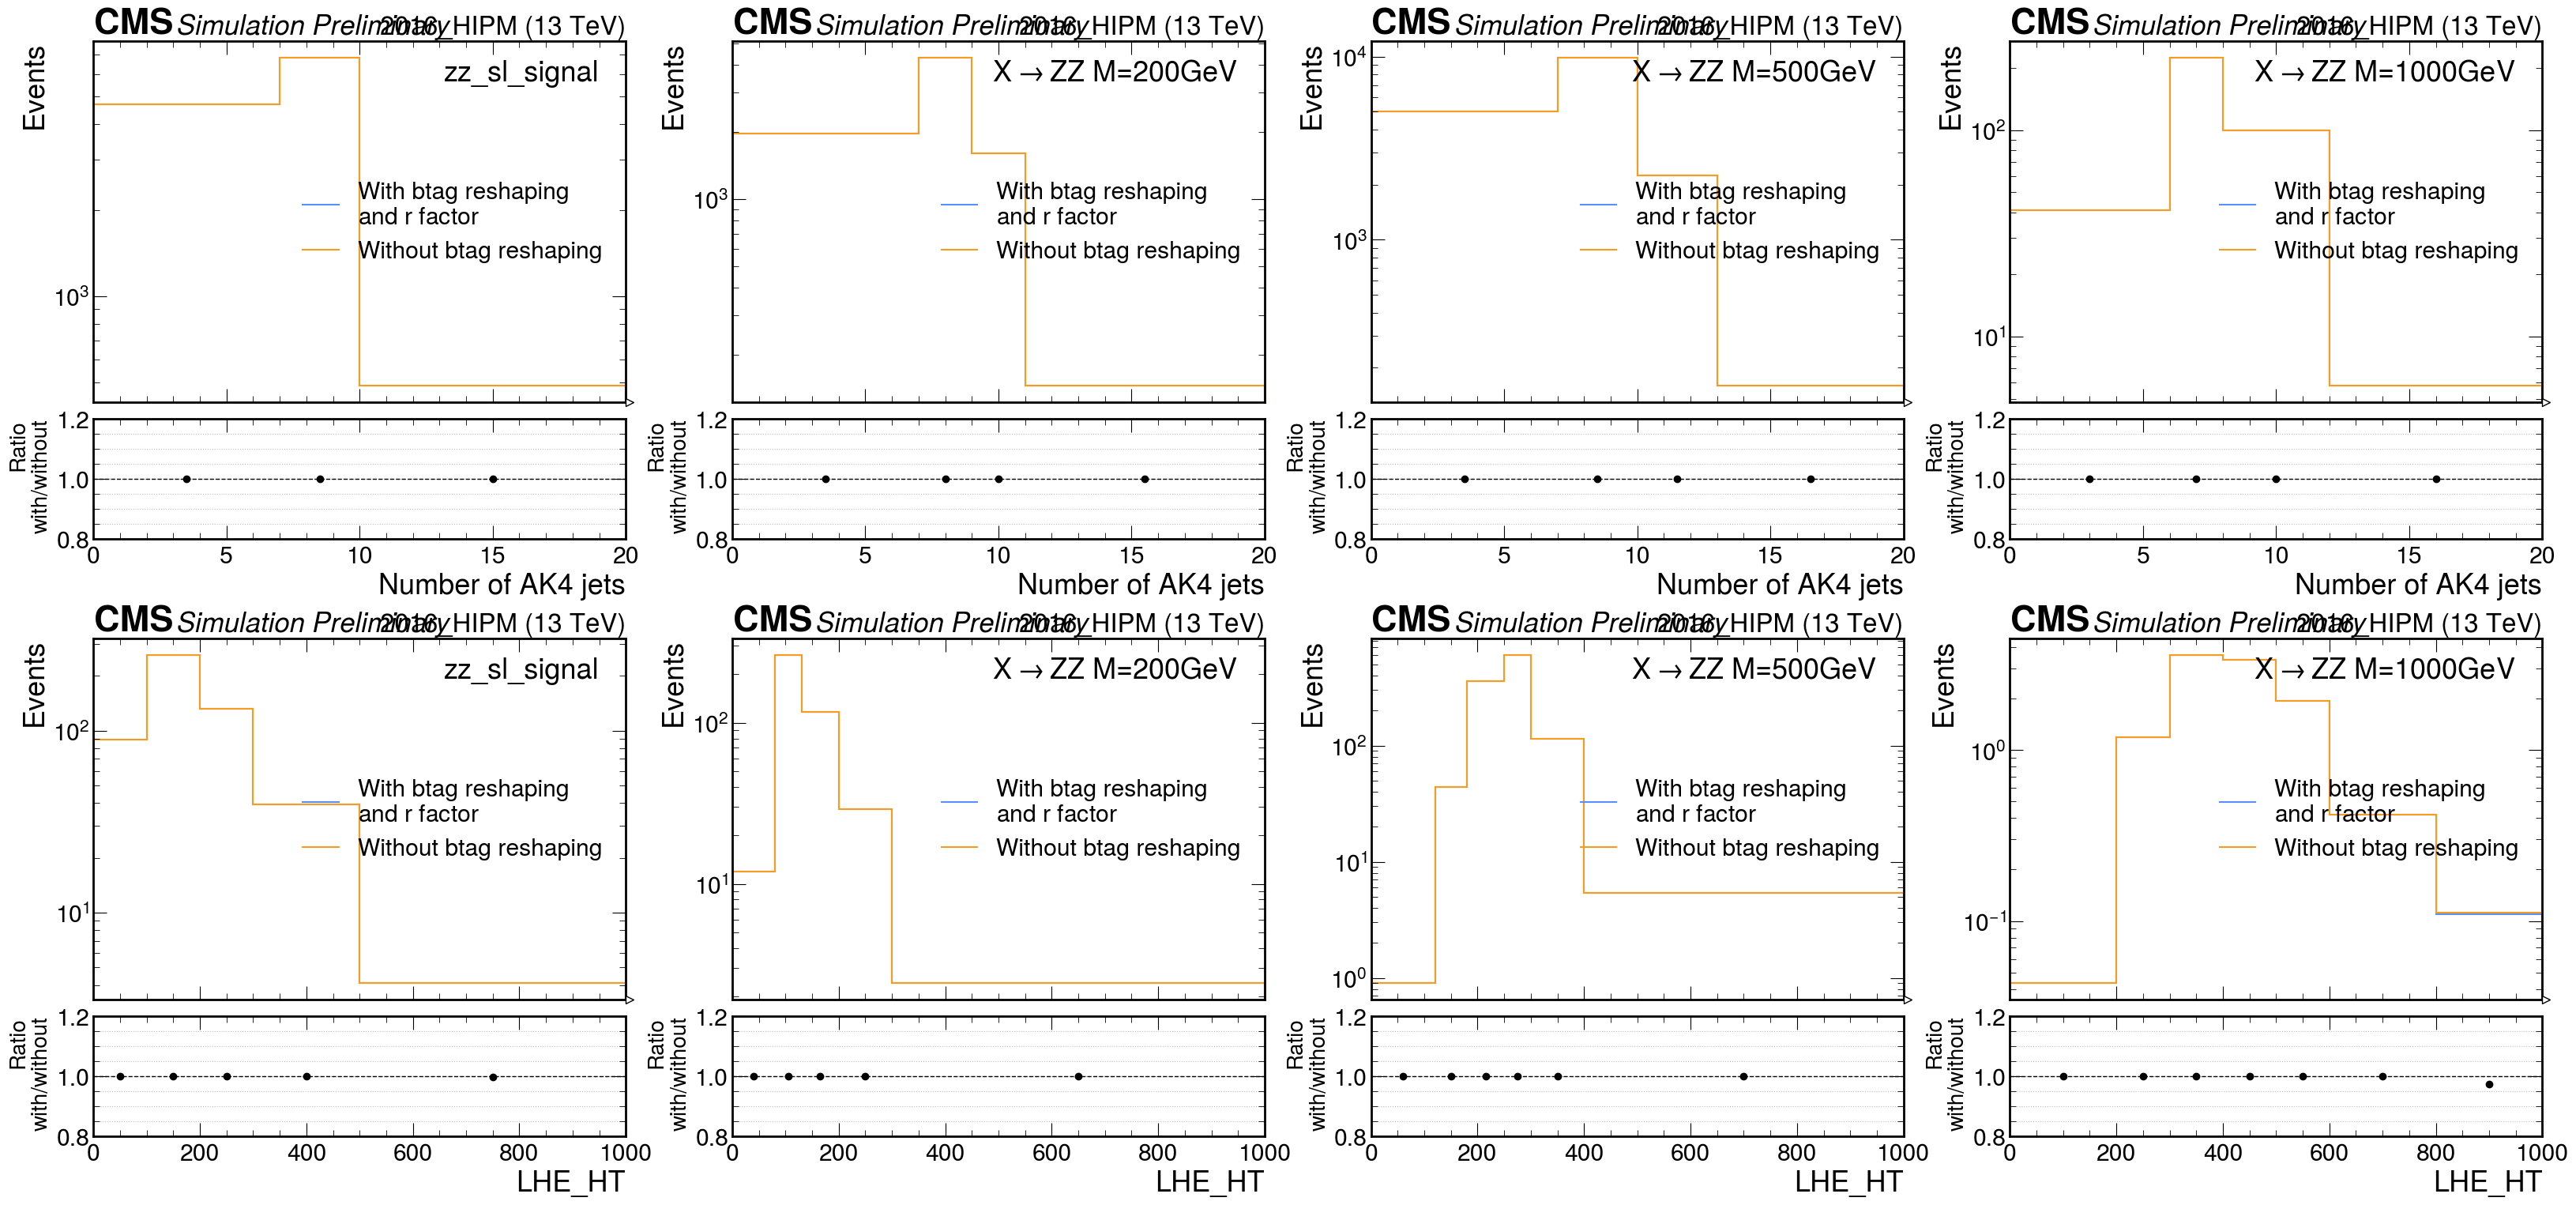

In [44]:
#### Big combined plot for AN
processes_sig = ["zz_sl_signal", "GluGluToXToZZTo2B2Tau_M200", "GluGluToXToZZTo2B2Tau_M500", "GluGluToXToZZTo2B2Tau_M1000"]
fig = plt.figure(figsize=(len(processes_sig)*10, len(features)*9))
outer = matplotlib.gridspec.GridSpec(len(features), len(processes_sig), wspace=0.2, hspace=0.2)
i = 0
for feature in features:
    for process  in processes_sig:
        hs_btag = open_preplot(feature=feature, process=process, region="baseline_region", with_btag=True, with_systs=False)
        hs_nobtag = open_preplot(feature=feature, process=process, region="baseline_region", with_btag=False, with_systs=False)
        if feature == "LHE_HT": rebin_tuple_idx = 1
        elif feature == "nJet": rebin_tuple_idx = 0
        else: rebin_tuple_idx = None
        if process == "zz_sl_signal" and rebin_tuple_idx is not None: 
            def rebin(h):
                return h[::get_rebin_signal_zz(0)[rebin_tuple_idx]]
        elif process.startswith("GluGluToX") and rebin_tuple_idx is not None:
            if feature == "LHE_HT":
                def rebin(h):
                    rebin_obj = get_rebin_signal_zz(int(process.split("_M")[-1]))[rebin_tuple_idx]
                    rebin_obj.edges = [x for x in rebin_obj.edges if x <1000] + [1000]
                    return h[::rebin_obj]
            else:
                def rebin(h):
                    return h[::get_rebin_signal_zz(int(process.split("_M")[-1]))[rebin_tuple_idx]]
            #def rebin(h): return h[::hist.rebin(edges=[0, 60, 100, 120, 140, 160, 180, 200, 250, 300, 1000])]
        elif feature == "LHE_HT":
            def rebin(h): return h[::hist.rebin(4)]
        else:
            rebin = lambda h:h
        h_btag = rebin(hs_btag["nominal"])
        h_nobtag = rebin(hs_nobtag["nominal"])

        reshape_extrap_ratio = 0.9671699313416069
        reshape_extrap_ratio = 1.
        import hist.plot
        grid = matplotlib.gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], hspace=0.07, height_ratios=[3, 1])
        #fig = plt.figure()
        #grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

        main_ax:plt.Axes = fig.add_subplot(grid[0])
        main_ax.set_yscale("log")
        main_ax.set_xlabel(" ")
        subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

        hep.histplot([h_btag*reshape_extrap_ratio, h_nobtag], yerr=False, label=["With btag reshaping\nand $r$ factor", "Without btag reshaping"], ax=main_ax, binwnorm=True)
        hist.plot.plot_ratio_array(h_btag, h_btag.values()*reshape_extrap_ratio/h_nobtag.values(), np.zeros_like(h_nobtag.values()), subplot_ax, ylim=(0.8,1.2), markersize=5)
        
        main_ax.set_ylabel("Events")
        subplot_ax.set_xlabel(feature_label.get(feature, feature))
        subplot_ax.set_ylabel("Ratio\nwith/without", size=20)
        plt.setp(main_ax.get_xticklabels(), visible=False)
        subplot_ax.grid(axis="y", which="both")
        hep.cms.label("Preliminary", year=year, fontsize=25, ax=main_ax)
        main_ax.text(0.95, 0.95, process_label_map.get(process, process), transform=main_ax.transAxes, ha="right", va="top")
        main_ax.legend(loc="right")

        i+=1
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/zz_signals_check_{year}.pdf", bbox_inches="tight")